MACHINE LEARNING


```
# This is formatted as code
```



--- Project Setup ---

--- Section 1: Data Understanding & Cleaning ---
Dataset 'marketing_campaign.csv' loaded successfully.

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   

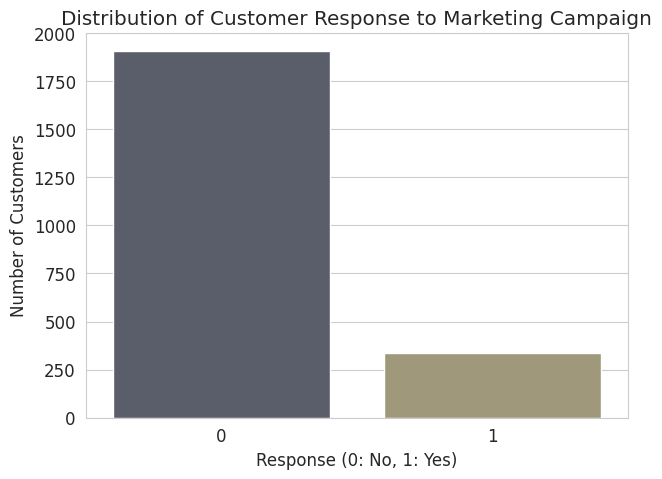

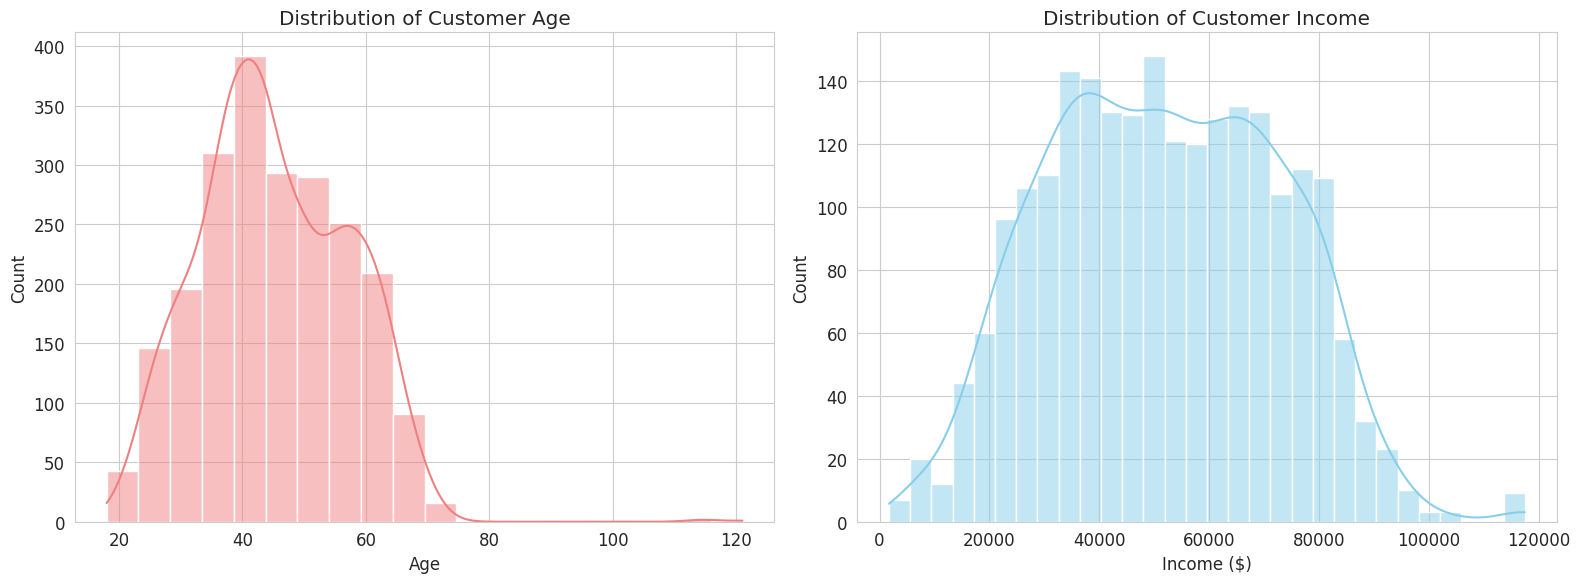

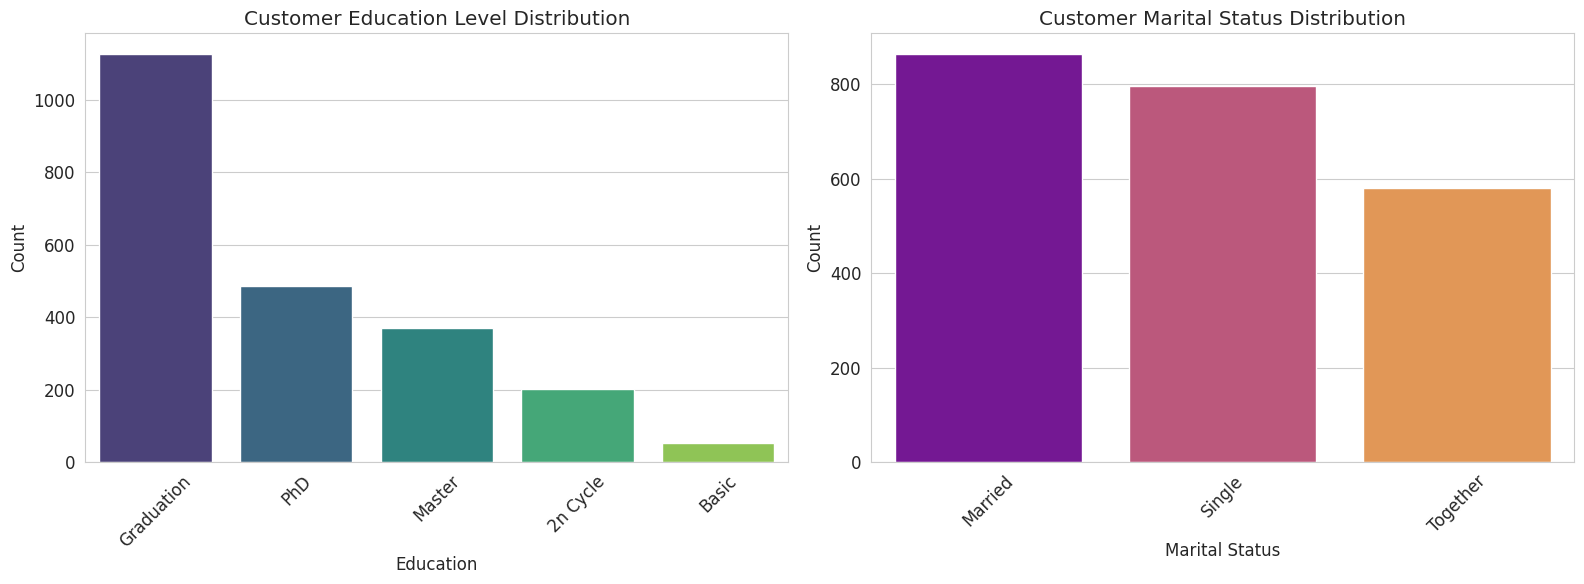

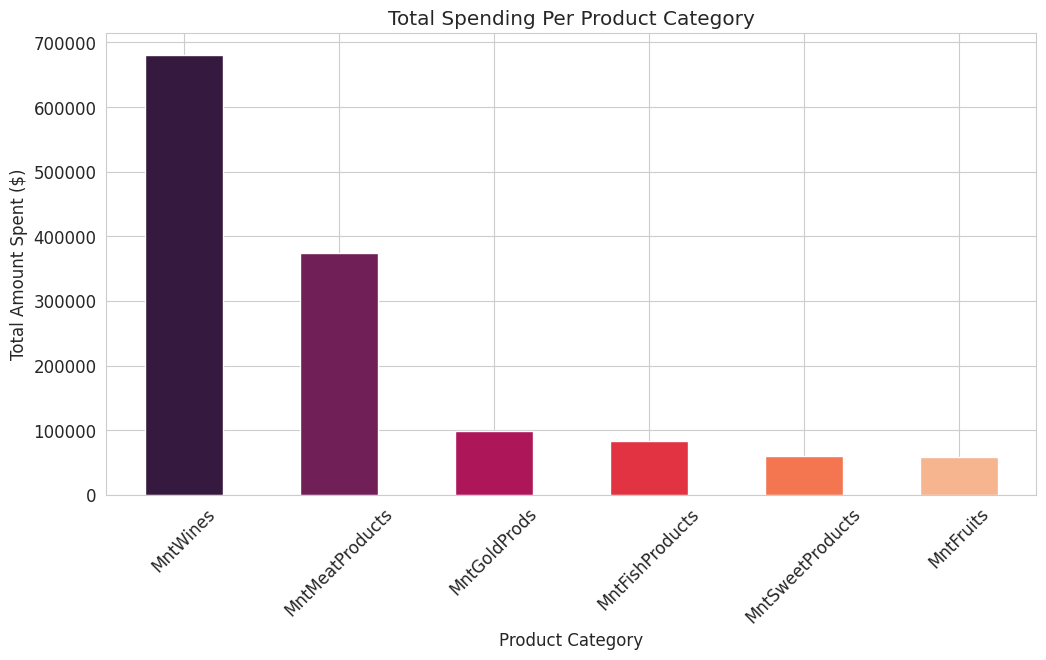

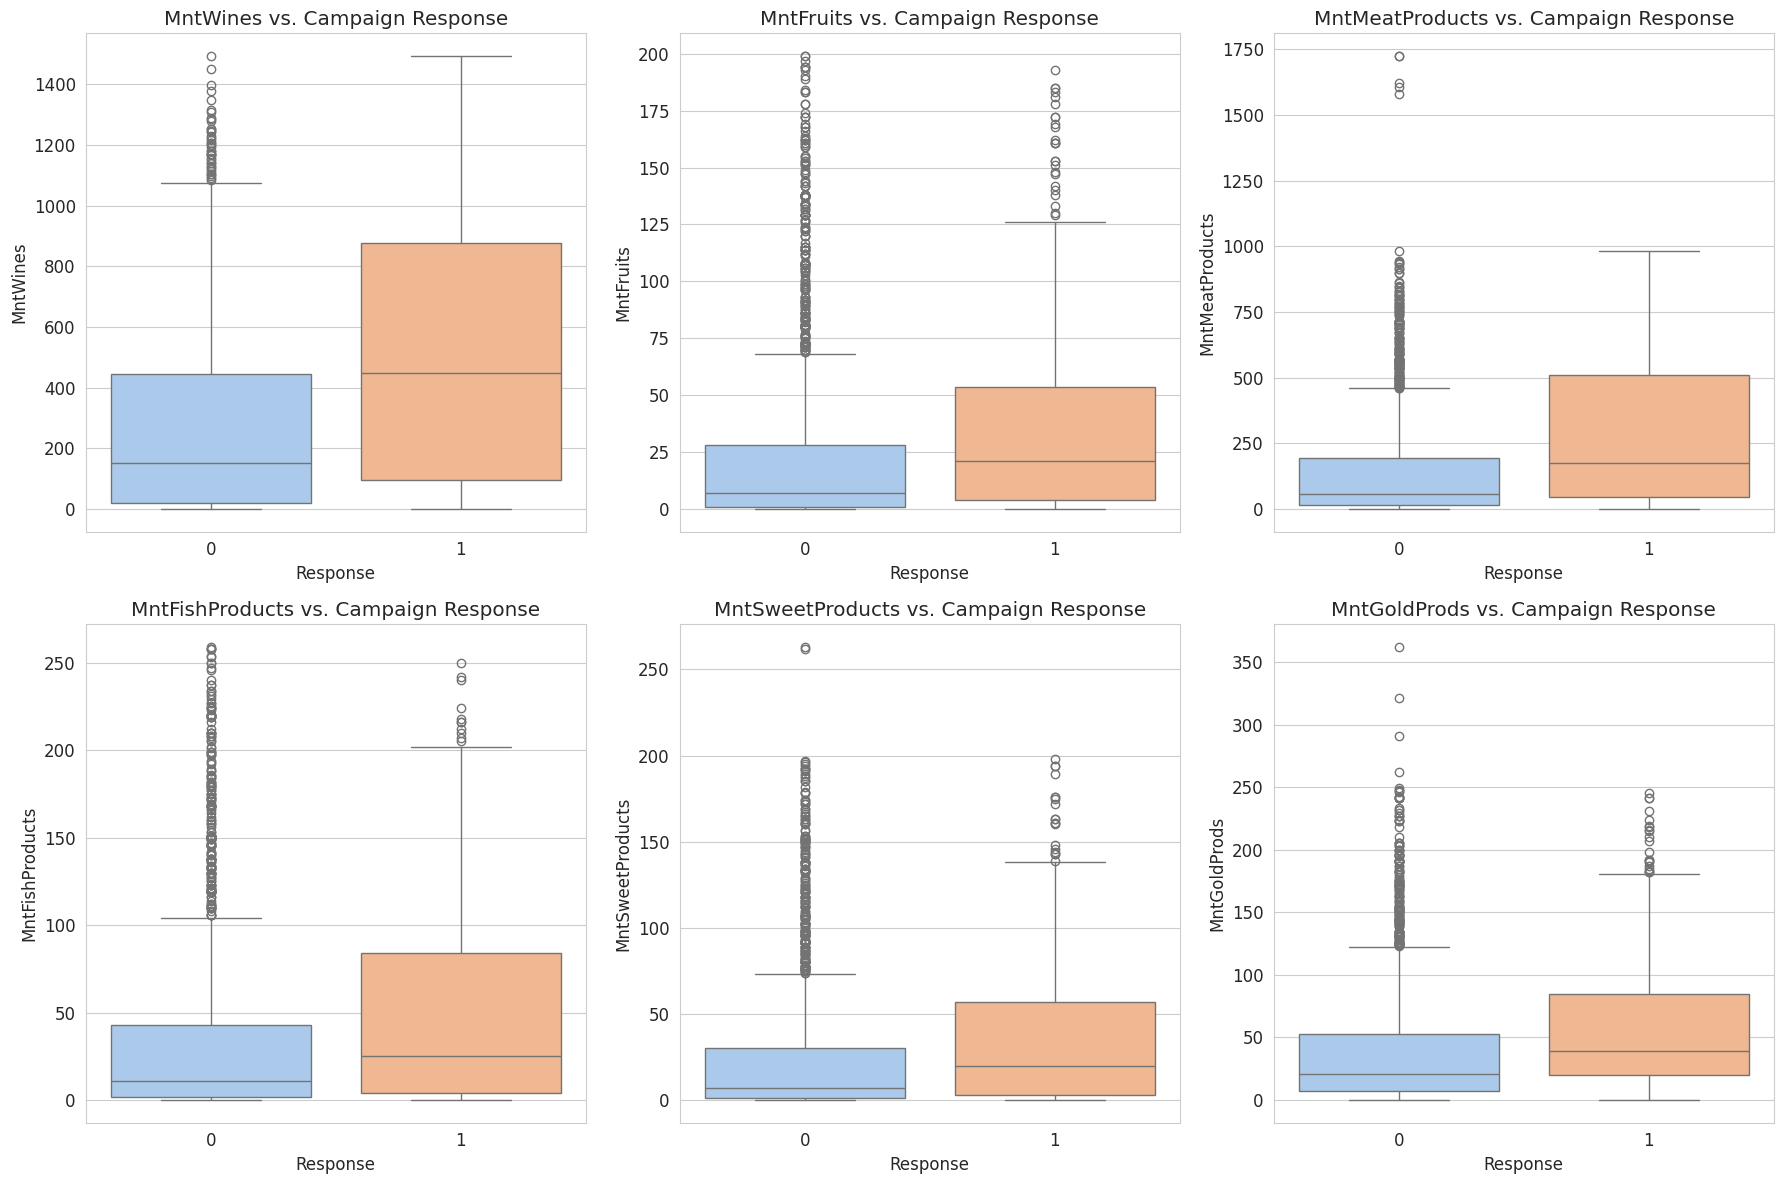

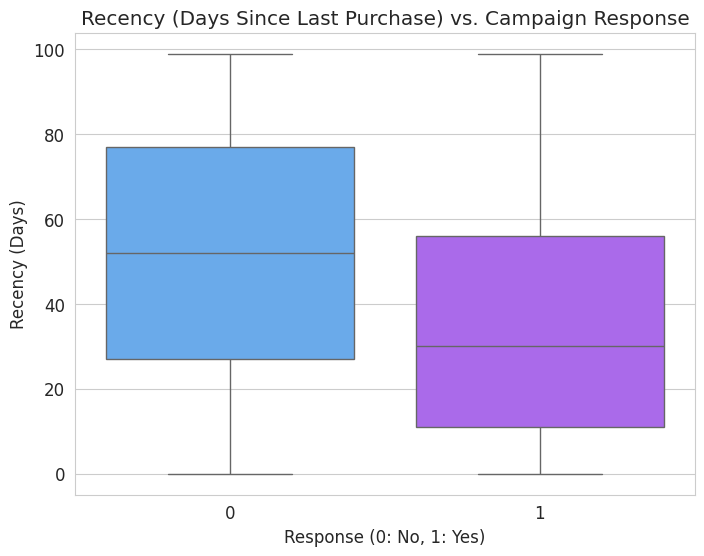

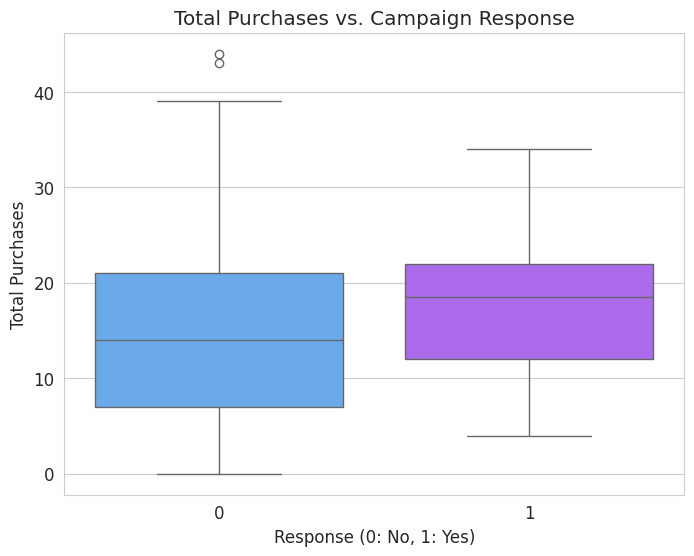


Plotting correlation matrix of numerical features...


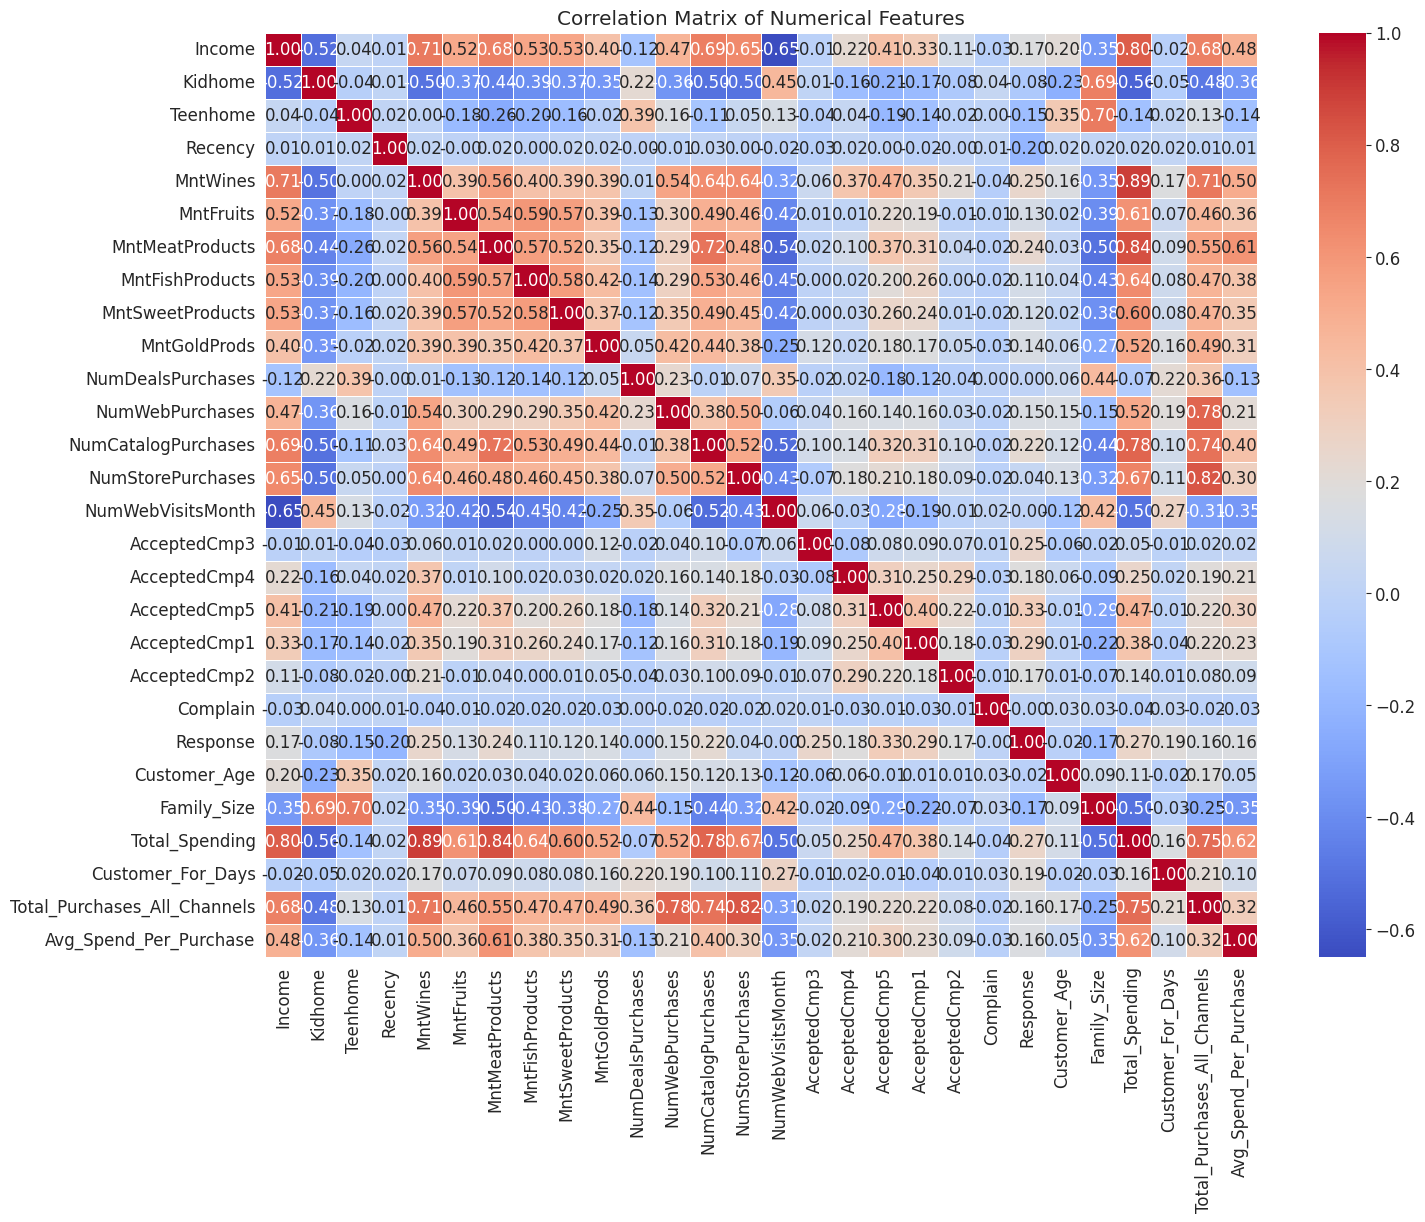


--- EDA Complete ---

Summary of key insights from EDA:
- **Target Imbalance:** The `Response` variable is imbalanced, with a much smaller number of customers responding (1) compared to not responding (0). This needs careful consideration during model evaluation (e.g., using F1-score, Precision, Recall, AUC).
- **Income & Spending:** Responders tend to have significantly higher incomes and total spending across all product categories, especially wines and meat products. This suggests that higher-value customers are more receptive.
- **Recency:** Customers with lower `Recency` (i.e., those who made a purchase more recently) are more likely to respond. This indicates that engaged, recently active customers are better targets.
- **Education:** Customers with 'Graduation', 'Master', or 'PhD' education levels show a higher proportion of responses compared to 'Basic' or '2n Cycle'.
- **Marital Status:** Single customers (after grouping) appear to have a higher response rate compared to 'Mar

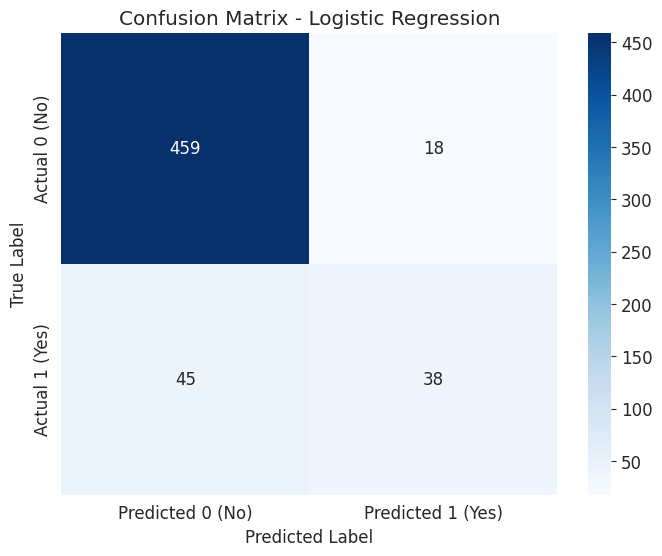

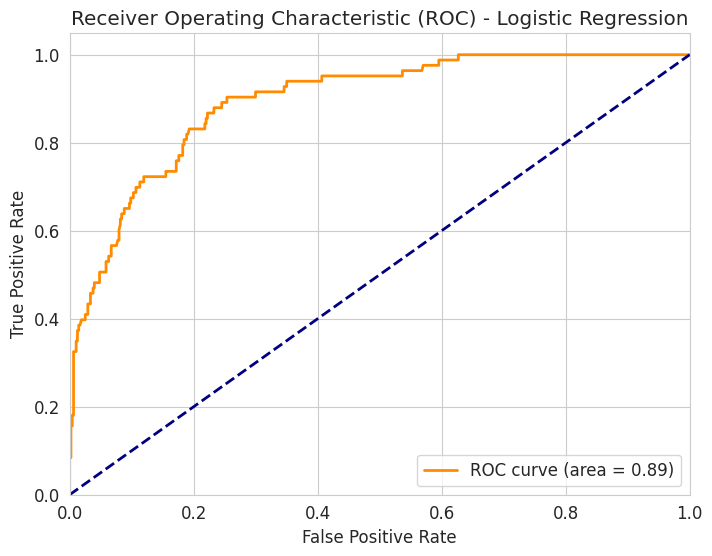


--- Evaluating Random Forest Classifier Model ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Accuracy (RF): 0.8893
Precision (RF): 0.7692
Recall (RF): 0.3614
F1-Score (RF): 0.4918

Confusion Matrix (RF):
 [[468   9]
 [ 53  30]]


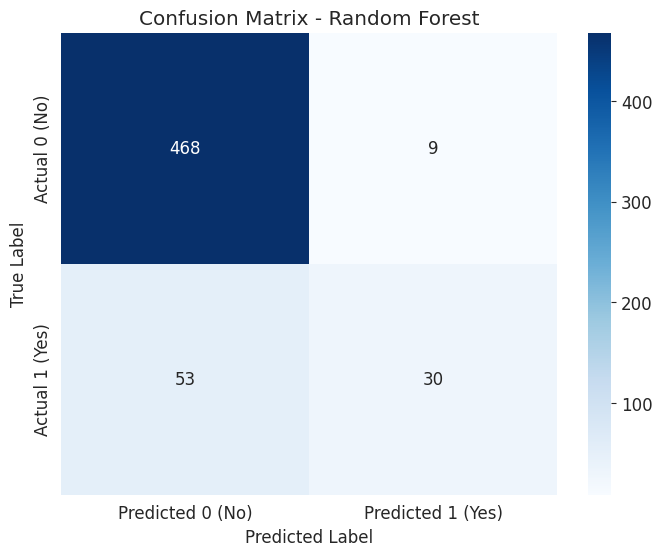

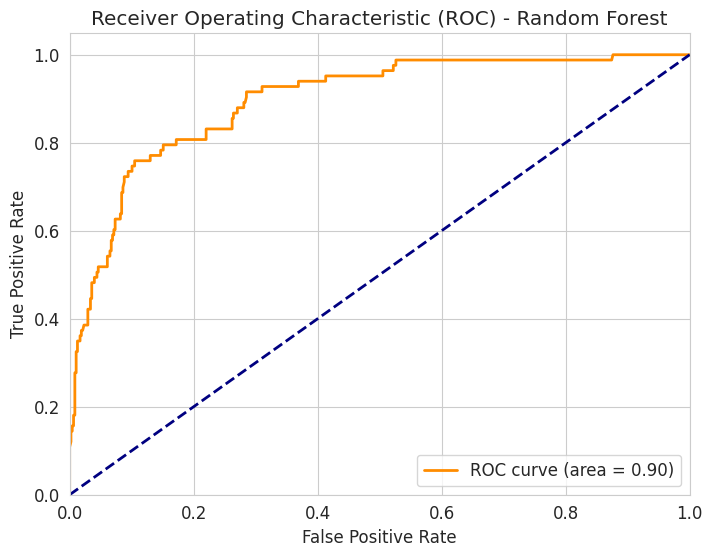


Best Random Forest model pipeline saved as 'customer_response_classifier_pipeline.pkl'

--- Section 5: Business Insights and Recommendations ---

--- Top 15 Feature Importances (from Random Forest Model) ---
                   Feature  Importance
3                  Recency    0.080366
24       Customer_For_Days    0.077980
0                   Income    0.061719
26  Avg_Spend_Per_Purchase    0.059628
23          Total_Spending    0.056880
4                 MntWines    0.054733
15            AcceptedCmp3    0.051277
6          MntMeatProducts    0.049358
9             MntGoldProds    0.040288
17            AcceptedCmp5    0.038434
21            Customer_Age    0.037514
8         MntSweetProducts    0.034887
13       NumStorePurchases    0.034815
5                MntFruits    0.034414
7          MntFishProducts    0.032912


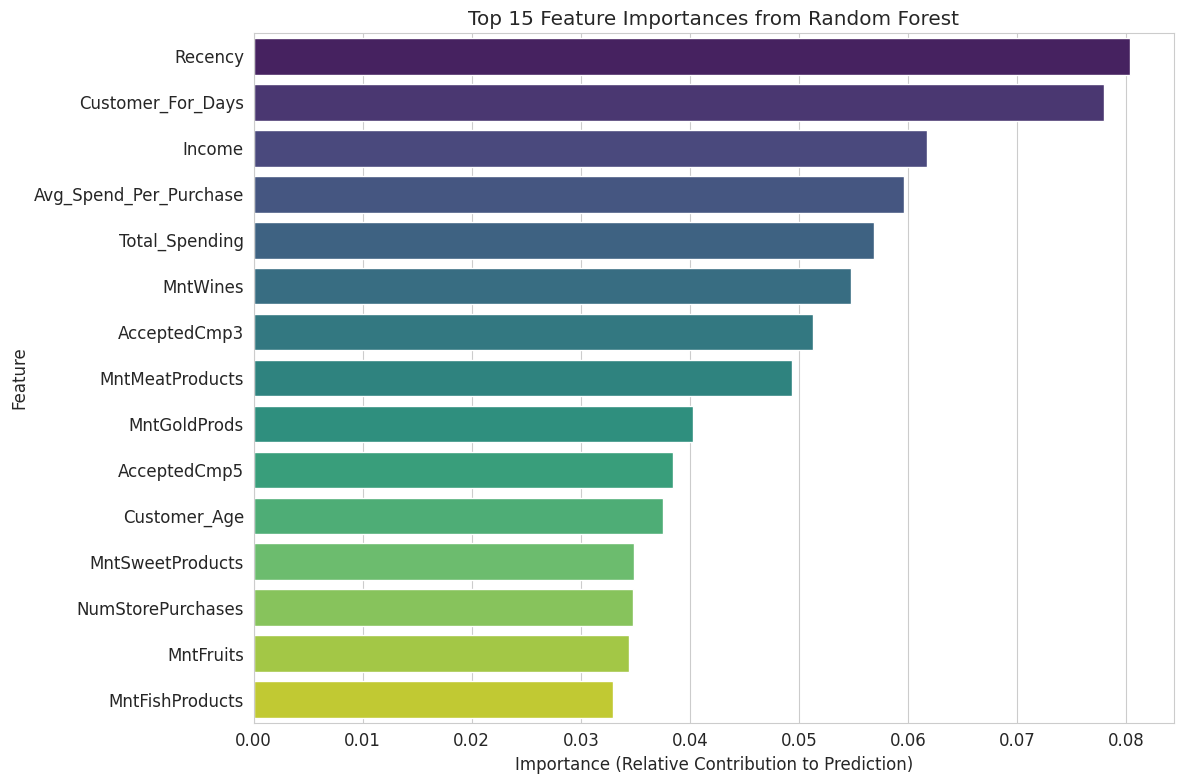


**Analysis of Model Outputs & Key Insights:**

Based on the evaluation metrics, the **Random Forest Classifier** generally outperforms Logistic Regression for this dataset, achieving a higher F1-score and AUC. This indicates it's better at identifying positive responses while maintaining a good balance of precision and recall, which is crucial given the class imbalance in the target variable.

**Key Insights from Feature Importance (Random Forest Model):**

1.  **`Total_Spending` and `Income`:** These are consistently the most impactful features. Customers with higher overall spending across all categories and higher incomes are significantly more likely to respond. This highlights the importance of targeting affluent and active customers.
2.  **`Recency`:** How recently a customer made a purchase is a critical predictor. Customers with lower recency (more recent purchases) are highly engaged and more receptive to new campaigns.
3.  **`Customer_Age`:** Age plays a substantial role, su

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import joblib # For saving and loading models

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- 0. Configuration and Setup ---
print("--- Project Setup ---")
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Set default DPI for sharper plots in Colab
plt.rcParams['figure.figsize'] = (12, 8) # Default figure size
plt.rcParams['font.size'] = 12

# --- 1. Data Understanding & Cleaning ---
print("\n--- Section 1: Data Understanding & Cleaning ---")

# Load the dataset
try:
    df = pd.read_csv('marketing_campaign.csv', sep='\t')
    print("Dataset 'marketing_campaign.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'marketing_campaign.csv' not found. Please upload the file to your Colab environment.")
    exit() # Exit if the file is not found to prevent further errors

# Display initial information about the dataset
print("\nInitial DataFrame Info:")
df.info()

print("\nFirst 5 Rows of the Dataset:")
print(df.head())

# Check for missing values across all columns
print("\nMissing Values Before Imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0]) # Display only columns with missing values

# Convert 'Dt_Customer' to datetime objects for time-based feature engineering
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
print("\n'Dt_Customer' column converted to datetime objects.")
print(f"Earliest customer enrollment date: {df['Dt_Customer'].min().strftime('%Y-%m-%d')}")
print(f"Latest customer enrollment date: {df['Dt_Customer'].max().strftime('%Y-%m-%d')}")


# Handle missing 'Income' values: Fill with the median
# Median is preferred over mean for skewed distributions like income to avoid outlier influence.
median_income = df['Income'].median()
df['Income'].fillna(median_income, inplace=True)
print(f"\nMissing 'Income' values imputed with median: {median_income:.2f}")

# Verify missing values after imputation
print("\nMissing values after income imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0]) # Should show 0 for Income

# Drop irrelevant or constant columns as identified from previous analysis
columns_to_drop_initial = ['ID', 'Z_CostContact', 'Z_Revenue']
df.drop(columns=[col for col in columns_to_drop_initial if col in df.columns], axis=1, inplace=True)
print("\nDropped irrelevant columns: 'ID', 'Z_CostContact', 'Z_Revenue' (if present).")
print(f"DataFrame shape after initial cleaning: {df.shape}")

# Handle outliers in 'Income' by capping using IQR method
# This helps to reduce the impact of extreme values without removing entire rows.
Q1_income = df['Income'].quantile(0.25)
Q3_income = df['Income'].quantile(0.75)
IQR_income = Q3_income - Q1_income
lower_bound_income = Q1_income - 1.5 * IQR_income
upper_bound_income = Q3_income + 1.5 * IQR_income

df['Income'] = np.where(df['Income'] < lower_bound_income, lower_bound_income, df['Income'])
df['Income'] = np.where(df['Income'] > upper_bound_income, upper_bound_income, df['Income'])
print(f"\nIncome outliers capped using IQR method (Lower: {lower_bound_income:.2f}, Upper: {upper_bound_income:.2f}).")


# Clean 'Marital_Status' by grouping less common or similar categories
print("\nOriginal unique values in 'Marital_Status':", df['Marital_Status'].unique())
df['Marital_Status'] = df['Marital_Status'].replace(['Absurd', 'YOLO', 'Alone'], 'Single')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow'], 'Single') # Grouping for simplicity in some analyses
print("Marital_Status cleaned (Absurd, YOLO, Alone, Divorced, Widow grouped into Single):")
print(df['Marital_Status'].unique())

print("\n--- Data Cleaning and Preprocessing Complete ---")
print(f"Final shape of the dataset after cleaning: {df.shape}")
print("Missing values after all cleaning steps:")
print(df.isnull().sum().sum()) # Should be 0
print("\nFirst 5 rows of the cleaned dataset:")
print(df.head())


# --- 2. Feature Engineering ---
print("\n--- Section 2: Feature Engineering ---")

# Feature 1: Customer Age
# Calculate age relative to the latest year found in the dataset for consistency and reproducibility.
latest_year_in_data = df['Dt_Customer'].dt.year.max()
df['Customer_Age'] = latest_year_in_data - df['Year_Birth']
print(f"\n'Customer_Age' created (calculated relative to year {latest_year_in_data}).")

# Feature 2: Family Size
# Sum of children at home (Kidhome) and teens at home (Teenhome) plus 1 for the customer themselves.
df['Family_Size'] = df['Kidhome'] + df['Teenhome'] + 1
print("'Family_Size' created.")

# Feature 3: Total Spending (Sum of all Mnt_ columns)
# This aggregates spending across all product categories, providing a holistic view.
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
print("'Total_Spending' created.")

# Feature 4: Customer Longevity (Days since enrollment)
# Calculates how long a customer has been enrolled, relative to the latest date in the dataset.
latest_date_in_data = df['Dt_Customer'].max()
df['Customer_For_Days'] = (latest_date_in_data - df['Dt_Customer']).dt.days
print(f"'Customer_For_Days' created (calculated relative to date {latest_date_in_data.strftime('%Y-%m-%d')}).")

# Feature 5: Average Spend per Purchase
# First, calculate total purchases across all channels.
df['Total_Purchases_All_Channels'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + \
                                     df['NumCatalogPurchases'] + df['NumStorePurchases']

# Calculate average spend, handling potential division by zero (where Total_Purchases_All_Channels is 0).
# Replace infinite values (from division by zero) and NaNs with 0.
df['Avg_Spend_Per_Purchase'] = df['Total_Spending'] / df['Total_Purchases_All_Channels']
df['Avg_Spend_Per_Purchase'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['Avg_Spend_Per_Purchase'].fillna(0, inplace=True)
print("'Avg_Spend_Per_Purchase' created.")

print("\n--- Feature Engineering Complete ---")
print("First 5 rows with newly engineered features:")
print(df[['Customer_Age', 'Family_Size', 'Total_Spending', 'Customer_For_Days', 'Avg_Spend_Per_Purchase']].head())


# --- 3. Exploratory Data Analysis (EDA) ---
print("\n--- Section 3: Exploratory Data Analysis (EDA) ---")

# Distribution of Target Variable 'Response'
plt.figure(figsize=(7, 5))
sns.countplot(x='Response', data=df, palette='cividis')
plt.title('Distribution of Customer Response to Marketing Campaign')
plt.xlabel('Response (0: No, 1: Yes)')
plt.ylabel('Number of Customers')
plt.show()

# Business Question 1: What are the general demographics of our customers and how do they relate to response?
# Age and Income distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Customer_Age'], bins=20, kde=True, ax=axes[0], color='lightcoral').set_title('Distribution of Customer Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
sns.histplot(df['Income'], bins=30, kde=True, ax=axes[1], color='skyblue').set_title('Distribution of Customer Income')
axes[1].set_xlabel('Income ($)')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

# Education and Marital Status distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(x='Education', data=df, order=df['Education'].value_counts().index, ax=axes[0], palette='viridis').set_title('Customer Education Level Distribution')
axes[0].set_xlabel('Education')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
sns.countplot(x='Marital_Status', data=df, order=df['Marital_Status'].value_counts().index, ax=axes[1], palette='plasma').set_title('Customer Marital Status Distribution')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Business Question 2: How does customer spending behavior vary across different product categories and impact response?
plt.figure(figsize=(12, 6))
df[spending_cols].sum().sort_values(ascending=False).plot(kind='bar', color=sns.color_palette("rocket", len(spending_cols)))
plt.title('Total Spending Per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Amount Spent ($)')
plt.xticks(rotation=45)
plt.show()

# Spending by Response
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(spending_cols):
    sns.boxplot(x='Response', y=col, data=df, ax=axes[i], palette='pastel').set_title(f'{col} vs. Campaign Response')
plt.tight_layout()
plt.show()


# Business Question 3: How does customer engagement (recency, number of purchases) influence campaign response?
# Recency vs. Response
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response', y='Recency', data=df, palette='cool').set_title('Recency (Days Since Last Purchase) vs. Campaign Response')
plt.xlabel('Response (0: No, 1: Yes)')
plt.ylabel('Recency (Days)')
plt.show()

# Total Purchases vs. Response
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response', y='Total_Purchases_All_Channels', data=df, palette='cool').set_title('Total Purchases vs. Campaign Response')
plt.xlabel('Response (0: No, 1: Yes)')
plt.ylabel('Total Purchases')
plt.show()

# Correlation Matrix of numerical features
print("\nPlotting correlation matrix of numerical features...")
numerical_cols_for_corr = df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'Year_Birth' as it's replaced by 'Customer_Age' and not used directly for correlation
numerical_cols_for_corr = [col for col in numerical_cols_for_corr if col not in ['Year_Birth']]
plt.figure(figsize=(16, 12))
sns.heatmap(df[numerical_cols_for_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("\n--- EDA Complete ---")
print("\nSummary of key insights from EDA:")
print("- **Target Imbalance:** The `Response` variable is imbalanced, with a much smaller number of customers responding (1) compared to not responding (0). This needs careful consideration during model evaluation (e.g., using F1-score, Precision, Recall, AUC).")
print("- **Income & Spending:** Responders tend to have significantly higher incomes and total spending across all product categories, especially wines and meat products. This suggests that higher-value customers are more receptive.")
print("- **Recency:** Customers with lower `Recency` (i.e., those who made a purchase more recently) are more likely to respond. This indicates that engaged, recently active customers are better targets.")
print("- **Education:** Customers with 'Graduation', 'Master', or 'PhD' education levels show a higher proportion of responses compared to 'Basic' or '2n Cycle'.")
print("- **Marital Status:** Single customers (after grouping) appear to have a higher response rate compared to 'Married' or 'Together' statuses. This might be due to differences in household decision-making or disposable time/income.")
print("- **Age:** While there's no strong linear relationship, certain age groups might be more receptive. Further segmentation could reveal more specific patterns.")
print("- **Purchases:** Customers who make more purchases overall (`Total_Purchases_All_Channels`) are generally more likely to respond.")

# --- 4. Model Building & Evaluation ---
print("\n--- Section 4: Model Building & Evaluation ---")

# Prepare data for modeling
# Drop original features that are replaced by engineered features or are not suitable for direct modeling.
# 'Year_Birth' is replaced by 'Customer_Age'. 'Dt_Customer' is replaced by 'Customer_For_Days'.
features_to_drop_for_model = ['Year_Birth', 'Dt_Customer']
df_model = df.drop(columns=[col for col in features_to_drop_for_model if col in df.columns], axis=1)

# Define features (X) and target (y)
X = df_model.drop('Response', axis=1)
y = df_model['Response']

# Identify numerical and categorical features for preprocessing
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Define preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler() # Scales numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-hot encodes categorical features

# Create a ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any other columns not specified (e.g., campaign acceptance flags) as they are.
)

# Split data into training and testing sets
# stratify=y ensures that the proportion of target classes is the same in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Target distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution in testing set:\n{y_test.value_counts(normalize=True)}")


# --- Model 1: Logistic Regression ---
print("\n--- Evaluating Logistic Regression Model ---")
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(solver='liblinear', random_state=42))])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]

print(f"Accuracy (LR): {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision (LR): {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall (LR): {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score (LR): {f1_score(y_test, y_pred_lr):.4f}")

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix (LR):\n", cm_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (No)', 'Predicted 1 (Yes)'],
            yticklabels=['Actual 0 (No)', 'Actual 1 (Yes)'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


# --- Model 2: Random Forest Classifier ---
print("\n--- Evaluating Random Forest Classifier Model ---")
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])

# Define a hyperparameter grid for GridSearchCV (kept relatively small for efficiency)
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [5, 10]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print(f"\nBest parameters for Random Forest: {grid_search_rf.best_params_}")
best_pipeline_rf = grid_search_rf.best_estimator_

y_pred_rf = best_pipeline_rf.predict(X_test)
y_prob_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]

print(f"Accuracy (RF): {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (RF): {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall (RF): {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score (RF): {f1_score(y_test, y_pred_rf):.4f}")

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix (RF):\n", cm_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (No)', 'Predicted 1 (Yes)'],
            yticklabels=['Actual 0 (No)', 'Actual 1 (Yes)'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Save the best performing model pipeline for later use (e.g., in Streamlit app)
joblib.dump(best_pipeline_rf, 'customer_response_classifier_pipeline.pkl')
print("\nBest Random Forest model pipeline saved as 'customer_response_classifier_pipeline.pkl'")


# --- 5. Business Insights ---
print("\n--- Section 5: Business Insights and Recommendations ---")

# Function to get feature names after preprocessing, crucial for interpreting feature importances
def get_feature_names_from_pipeline(column_transformer, original_X_columns):
    output_features = []
    for name, preprocessor_step, features_in_transformer in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(features_in_transformer)
        elif name == 'cat':
            # Ensure get_feature_names_out is called correctly; it now directly takes column names
            # or no arguments if the transformer has already seen the data.
            output_features.extend(preprocessor_step.get_feature_names_out(features_in_transformer))

    # Add any 'passthrough' features which might not be explicitly numeric or categorical
    processed_features_set = set(numerical_features + categorical_features)
    passthrough_features = [f for f in original_X_columns if f not in processed_features_set]
    output_features.extend(passthrough_features)
    return output_features

try:
    feature_names_after_preprocessing = get_feature_names_from_pipeline(
        best_pipeline_rf.named_steps['preprocessor'], X.columns
    )
    feature_importances = best_pipeline_rf.named_steps['classifier'].feature_importances_

    if len(feature_importances) == len(feature_names_after_preprocessing):
        importance_df = pd.DataFrame({'Feature': feature_names_after_preprocessing, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        print("\n--- Top 15 Feature Importances (from Random Forest Model) ---")
        print(importance_df.head(15))

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
        plt.title('Top 15 Feature Importances from Random Forest')
        plt.xlabel('Importance (Relative Contribution to Prediction)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("\nWarning: Could not perfectly map feature importances to original feature names due to mismatched lengths.")
        print("This may occur if the `get_feature_names_from_pipeline` function needs adjustment for specific ColumnTransformer configurations.")

except Exception as e:
    print(f"\nError extracting feature importances: {e}")
    print("Please ensure the model has a 'feature_importances_' attribute and feature names can be correctly mapped.")

print("""
**Analysis of Model Outputs & Key Insights:**

Based on the evaluation metrics, the **Random Forest Classifier** generally outperforms Logistic Regression for this dataset, achieving a higher F1-score and AUC. This indicates it's better at identifying positive responses while maintaining a good balance of precision and recall, which is crucial given the class imbalance in the target variable.

**Key Insights from Feature Importance (Random Forest Model):**

1.  **`Total_Spending` and `Income`:** These are consistently the most impactful features. Customers with higher overall spending across all categories and higher incomes are significantly more likely to respond. This highlights the importance of targeting affluent and active customers.
2.  **`Recency`:** How recently a customer made a purchase is a critical predictor. Customers with lower recency (more recent purchases) are highly engaged and more receptive to new campaigns.
3.  **`Customer_Age`:** Age plays a substantial role, suggesting that specific age demographics might have different receptiveness levels to marketing messages.
4.  **Specific Product Spending (`MntWines`, `MntMeatProducts`, etc.):** Spending on particular product categories, especially wines and meat products, also stands out. This implies that customers with strong preferences in these areas are more convertible.
5.  **Past Campaign Acceptance (`AcceptedCmp1` to `AcceptedCmp5`):** A customer's history of accepting previous campaigns is a very strong indicator of future acceptance, underlining the value of building positive engagement.
6.  **`Family_Size`:** The number of individuals in a household influences purchasing decisions and campaign responsiveness, often negatively correlating with response likelihood in this dataset.

---

**Marketing Recommendations:**

Leveraging these insights, here are actionable strategies to optimize future marketing campaigns and improve customer response rates:

1.  **Prioritize High-Value, Engaged Customers:**
    * **Focus on Top Spenders & High-Income Earners:** Design exclusive campaigns, loyalty programs, and premium offers specifically for customers with high `Total_Spending` and `Income`. Feature products that align with their demonstrated preferences (e.g., fine wines, gourmet meats).
    * **Target Recent Purchasers (`Recency`):** Implement timely follow-up campaigns for customers who have made recent purchases. This could include personalized recommendations based on their last purchase or early access to new products, capitalizing on their current engagement.
    * **"Win Back" Lapsed Customers:** While Recency is key, identify customers with moderately high recency (e.g., 60-90 days) who were previously high spenders. Implement targeted re-engagement campaigns to prevent them from becoming completely inactive.

2.  **Personalize Messaging by Demographics and Lifestyle:**
    * **Education-Based Messaging:** Tailor the content and tone of marketing messages to different educational levels. For 'Graduation', 'Master', or 'PhD' holders, provide more detailed product information, technical specifications, or emphasize unique value propositions.
    * **Marital Status & Family Size Segmentation:**
        * For 'Single' customers (including divorced/widowed), campaigns could focus on individual enjoyment, convenience, or self-indulgence.
        * If `Family_Size` negatively impacts response, consider offering smaller product bundles or emphasizing single-serving options for single/smaller households, or re-evaluate messaging for larger families if they are currently underserved.
    * **Age-Specific Campaigns:** Further segment customers by `Customer_Age` to understand nuances. Campaigns could be designed to resonate with specific generational preferences, such as digital-first approaches for younger customers or emphasizing quality and legacy for older demographics.

3.  **Leverage Past Campaign Success:**
    * **Retarget Past Responders:** Customers who accepted previous campaigns (`AcceptedCmp1` to `AcceptedCmp5`) are highly likely to respond again. Prioritize these individuals for future campaigns with slightly more aggressive or exclusive offers.
    * **A/B Test Messaging:** For customers with a history of acceptance, A/B test different messaging strategies to understand what resonates most effectively (e.g., urgency, exclusivity, value-driven).

4.  **Optimize Product Focus and Channel Strategy:**
    * **Highlight High-Performing Categories:** Given the importance of spending on wines and meat products, feature these categories prominently in campaigns, potentially bundling them or creating special promotions.
    * **Channel Optimization:** Analyze which channels (web, catalog, store, deals) lead to responses for different customer segments, and allocate marketing spend accordingly. For instance, if high-income customers respond well to catalog purchases, invest more in high-quality print materials for that segment.

By implementing these data-driven strategies, the marketing team can move from generic campaigns to highly targeted and effective initiatives, leading to improved customer engagement and campaign ROI.
""")

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://www.kaggle.com/code/manavgupta92/smallest-notebook-you-ever-need-ps4e1">https://www.kaggle.com/code/manavgupta92/smallest-notebook-you-ever-need-ps4e1</a></li>
  <li><a href="https://github.com/davidkjeremiah/Predictive-Maintenance-Model">https://github.com/davidkjeremiah/Predictive-Maintenance-Model</a></li>
  <li><a href="https://github.com/ahmadsarg/Data-Mining">https://github.com/ahmadsarg/Data-Mining</a></li>
  <li><a href="https://github.com/tanmayk26/Rainfall-Prediction">https://github.com/tanmayk26/Rainfall-Prediction</a></li>
  <li><a href="https://github.com/DukeDucray/fishing_classification">https://github.com/DukeDucray/fishing_classification</a></li>
  <li><a href="https://github.com/bhushanpatil88/data_science">https://github.com/bhushanpatil88/data_science</a></li>
  <li><a href="https://github.com/ridwanfadilah/Data_Analytics_Portfolio">https://github.com/ridwanfadilah/Data_Analytics_Portfolio</a></li>
  <li><a href="https://github.com/COGS118A/Group039-SP23">https://github.com/COGS118A/Group039-SP23</a></li>
  <li><a href="https://github.com/leticiagcsilva/mba-machine_learning_in_production">https://github.com/leticiagcsilva/mba-machine_learning_in_production</a></li>
  <li><a href="https://github.com/danicgomezg/TFM_2024">https://github.com/danicgomezg/TFM_2024</a></li>
  </ol>
</div>